In [1]:
from datascience import *
import matplotlib
matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plots
%matplotlib inline
plots.style.use('fivethirtyeight')
#plots.style.use('ggplot')
#plots.style.use('seaborn')
import numpy as np
np.set_printoptions(threshold=50)
import random
from scipy import stats
import math, copy

In [2]:
def flipCoin( p ):
    r = random.random()
    return r < p

def argMax(counter):
    """Take in a dict type and return the key with the highest value. Random to break tie."""
    if len(counter.keys()) == 0: return None
    all = counter.items()
    values = [x[1] for x in all]
    optIndexes = []
    for i in range(len(values)):
        if values[i] == max(values):
            optIndexes.append(i)
    maxIndex = random.choice(optIndexes)
    return list(all)[maxIndex][0]

def cumulative_sum(arr):
    result = []
    s = 0
    for i in range(len(arr)):
        s = s + arr[i]
        result.append(s)
    return result

class Beta:
    def __init__(self, alpha = 1, beta = 1):
        self.alpha = alpha
        self.beta  = beta
    
    def sample(self):
        return random.betavariate(self.alpha, self.beta)
    
    def expectation(self):
        return self.alpha / (self.alpha + self.beta)
    
    def variance(self):
        a = self.alpha
        b = self.beta
        return a*b/((a+b)**2*(a+b+1))
    
    def interval(self, confidence = 0.95):
        return stats.beta.interval(confidence, self.alpha, self.beta)

class Normal:
    def __init__(self, mu = 0, var = 1):
        self.mu = mu
        self.var = var
    
    def sample(self):
        return random.normalvariate(self.mu, math.sqrt(self.var))
    
    def expectation(self):
        return self.mu
    
    def variance(self):
        return self.var
    
    def interval(self, confidence = 0.95):
        return stats.norm.interval(confidence, self.mu, math.sqrt(self.var))

ARM_1, ARM_2 = 1, 2
ARMS = (ARM_1, ARM_2)

class BanditSystem:
    def __init__(self, p = 1):
        self.theta = [0, 0, 1]
        self.p = p
        self.record_revenue = []
    
    def pull(self, j):
        """
        Pull arm j and return the reward from the bandit system.
        """
        assert j in ARMS
        allocation = flipCoin(self.theta[j])
        price = self.p * allocation
        self.record_revenue.append(price)
        return allocation, price

bandit1 = BanditSystem(p = 0.25-0.0001)
bandit2 = BanditSystem(p = 0.75)

class BanditAlgorithm:
    """
    Template class for bandit algorithms.
    """
    def __init__(self):
        """
        Set the parameters needed for the bandit algorithm.
        """
        self.record_reward = []
        self.record_expecti_theta = []
        self.record_actions = []
    
    def reset(self):
        """
        Reset the parameters.
        This will be implemented in subclasses by concrete algorithm.
        """
        raise NotImplementedError
    
    def getAction(self):
        """
        Return the arm choose to pull based on the current experience.
        This will be implemented in subclasses by concrete algorithm.
        """
        raise NotImplementedError
        
    def update(self, action, reward):
        """
        Update the knowledgement of the bandit system based on the result of last trial.
        This will be implemented in subclasses by concrete algorithm.
        """
        raise NotImplementedError
    
    def getExpectiTheta(self):
        """
        Return the expecti-value of theta for each arm based on current experience.
        Only for plotting.
        This will be implemented in subclasses by concrete algorithm.
        """
        raise NotImplementedError
    
    def run(self, bandit):
        """
        Run the algorithm once.
        """
        arm = self.getAction()
        allocation, price = bandit.pull(arm)
        reward = self.valuation(allocation) - price
        self.update(arm, reward)
        
        self.record_actions.append(arm)
        self.record_reward.append(reward)
        self.record_expecti_theta.append(self.getExpectiTheta())


class EpsilonGreedy (BanditAlgorithm):
    def __init__(self, epsilon = 0.8, v = 0.5):
        self.valuation = lambda x: x*v
        self.epsilon = epsilon
        self.reset()
    
    def reset(self):
        BanditAlgorithm.__init__(self)
        self.estimated_theta = {ARM_1: 0, ARM_2: 0}
        self.counter_of = {ARM_1: 0, ARM_2: 0}
        
    def getAction(self):
        if flipCoin(self.epsilon):
            return random.choice(ARMS)
        else:
            return argMax(self.estimated_theta)
    
    def update(self, action, reward):
        self.counter_of[action] += 1
        self.estimated_theta[action] += (reward - self.estimated_theta[action])/self.counter_of[action]
    
    def getExpectiTheta(self):
        return tuple(self.estimated_theta[arm] for arm in ARMS)

class UCB (BanditAlgorithm):
    def __init__(self, c = 1, v = 0.5):
        self.valuation = lambda x: x*v
        self.c = c
        self.reset()
        
    def reset(self):
        BanditAlgorithm.__init__(self)
        self.estimated_theta = {ARM_1: 0, ARM_2: 0}
        self.counter_of = {ARM_1: 0, ARM_2: 0}
    
    def getAction(self):
        assessment = {}
        t = sum(self.counter_of.values())
        for arm in ARMS:
            if self.counter_of[arm] == 0:
                return arm
            assessment[arm] = self.estimated_theta[arm] + self.c * math.sqrt(2*math.log(t)/self.counter_of[arm])
        return argMax(assessment)
    
    def update(self, action, reward):
        self.counter_of[action] += 1
        self.estimated_theta[action] += (reward - self.estimated_theta[action])/self.counter_of[action]
    
    def getExpectiTheta(self):
        return tuple(self.estimated_theta[arm] for arm in ARMS)

class ThompsonSampling (BanditAlgorithm):
    def __init__(self, piror_distributions, do_record_intervals = False, v = 0.5):
        self.valuation = lambda x: x*v
        self.do_record_intervals = do_record_intervals
        self.piror_distributions = piror_distributions
        self.reset()
        
    def reset(self):
        BanditAlgorithm.__init__(self)
        if self.do_record_intervals:
            self.record_intervals = []
        self.theta_distributions = copy.deepcopy(self.piror_distributions)
    
    def getAction(self):
        sample_theta = {}
        for arm in ARMS:
            sample_theta[arm] = self.theta_distributions[arm].sample()
        return argMax(sample_theta)
    
    def update(self, action, reward):
        self.theta_distributions[action].alpha += reward
        self.theta_distributions[action].beta  += 1 - reward
        if self.do_record_intervals:
            self.record_intervals.append(tuple(self.theta_distributions[arm].interval() for arm in ARMS))
    
    def getExpectiTheta(self):
        return tuple(self.theta_distributions[arm].expectation() for arm in ARMS)

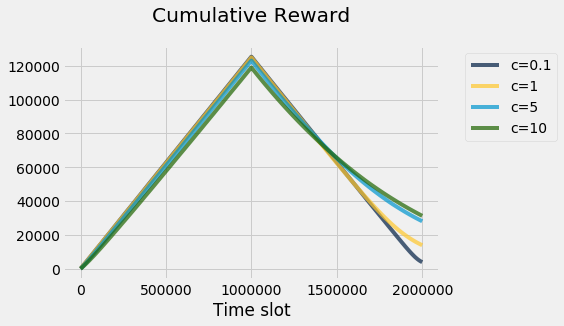

In [3]:
def plot_and_get_reward(c=1):
    record_reward = []
    cumulative_record_reward = []

    agent1 = UCB(c=c, v=0.25)
    agent2 = UCB(c=c, v=0.5)
    N = 1000000
    last_reward = 0
    for _ in range(N):
        valuation = 0.25 if flipCoin(0.5) else 0.5
        if valuation == 0.25:
            agent = agent1
        else:
            agent = agent2
        agent.run(bandit=bandit1)
        record_reward.append(agent.record_reward[-1])
        last_reward += agent.record_reward[-1]
        cumulative_record_reward.append(last_reward)
    for _ in range(N):
        valuation = 0.25 if flipCoin(0.5) else 0.5
        if valuation == 0.25:
            agent = agent1
        else:
            agent = agent2
        agent.run(bandit=bandit2)
        record_reward.append(agent.record_reward[-1])
        last_reward += agent.record_reward[-1]
        cumulative_record_reward.append(last_reward)
    # print(sum(agent1.record_reward), sum(agent2.record_reward), str(sum(bandit2.record_revenue))+'/'+str(N//4*3), sum(bandit2.record_revenue)/N/2)

    record_reward = np.array(record_reward)
    cumulative_record_reward = np.array(cumulative_record_reward)
    return cumulative_record_reward
    
N = 1000000
table_1 = Table().with_columns(
    'Time slot', np.arange(1,2*N+1),
    # 'Reward', record_reward,
    'c=0.1', plot_and_get_reward(c=0.1),
    'c=1', plot_and_get_reward(c=1),
    'c=5', plot_and_get_reward(c=5),
    'c=10', plot_and_get_reward(c=10),
)
table_1.plot('Time slot')
plots.title('Cumulative Reward', y=1.08);